# Interest Analysis


In [79]:
!nvidia-smi

Mon May 25 16:15:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   3723MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q -U watermark

In [0]:
!pip install -qq transformers

In [9]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.3
torch 1.5.0+cu101
transformers 2.10.0


In [0]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch

import numpy as np

import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

import os.path

from os import path

%matplotlib inline

%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Mounting google drive to import dataset files

In [15]:
!pip install PyDrive

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Creation of data frame 

In [19]:
input_files = ['shopping and  fashion','Food and drink', 'technology',
               'Business and Industry','Entertainment','Family and Relationships',
               'Fitness and Wellness','Hobbies and activities','Sports and Outdoors']
col_list = ["captions", "interest"]
dfs = []
folder_path="/content/gdrive/My Drive/interest_dataset_folder/dataset/"
for input_file in input_files:
  cur_path=folder_path+input_file+".csv"
  if path.exists(cur_path):
    print(input_file)
    dfs.append(pd.read_csv(cur_path, usecols=col_list,engine='python',
                           encoding='utf-8', error_bad_lines=False,nrows=10000))
df = pd.concat(dfs, ignore_index=True)
df = df.dropna()
df.loc[df.interest == "buisness", "interest"] = "business"
print(len(dfs))
df.head(100000)

shopping and  fashion
Food and drink
technology
Business and Industry
Entertainment
Family and Relationships
Fitness and Wellness
Hobbies and activities
Sports and Outdoors
9


,captions,interest
0,Hit the link in our bio to see our latest inte...,shopping and fashion
1,Caption this,shopping and fashion
2,"Alright, alight, alright. Here's @officiallymc...",shopping and fashion
3,Here's why a peak lapel grey overcoat is alway...,shopping and fashion
4,"Kit Harington, making travelling in style look...",shopping and fashion
...,...,...
87814,"DOMINANCE 20 years ago, on his 28th birthday, ...",Sports and Outdoors
87815,LeBron put up ridiculous numbers when he was 2...,Sports and Outdoors
87816,Tom Brady picks the strawweight queen to defen...,Sports and Outdoors
87817,For @shaq's 48th birthday we present a Shaq-ti...,Sports and Outdoors


In [20]:
df.info()
df.interest.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85502 entries, 0 to 87818
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  85502 non-null  object
 1   interest  85502 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


array(['shopping and  fashion', 'food and drink', 'technology',
       'Business and Industry', 'entertainment',
       'Family and Relationships', 'Fitness and Wellness',
       'hobbies and activities', 'Sports and Outdoors'], dtype=object)

Great, no missing values in the score and review texts! Do we have class imbalance?

sahh congoloxicomatisation


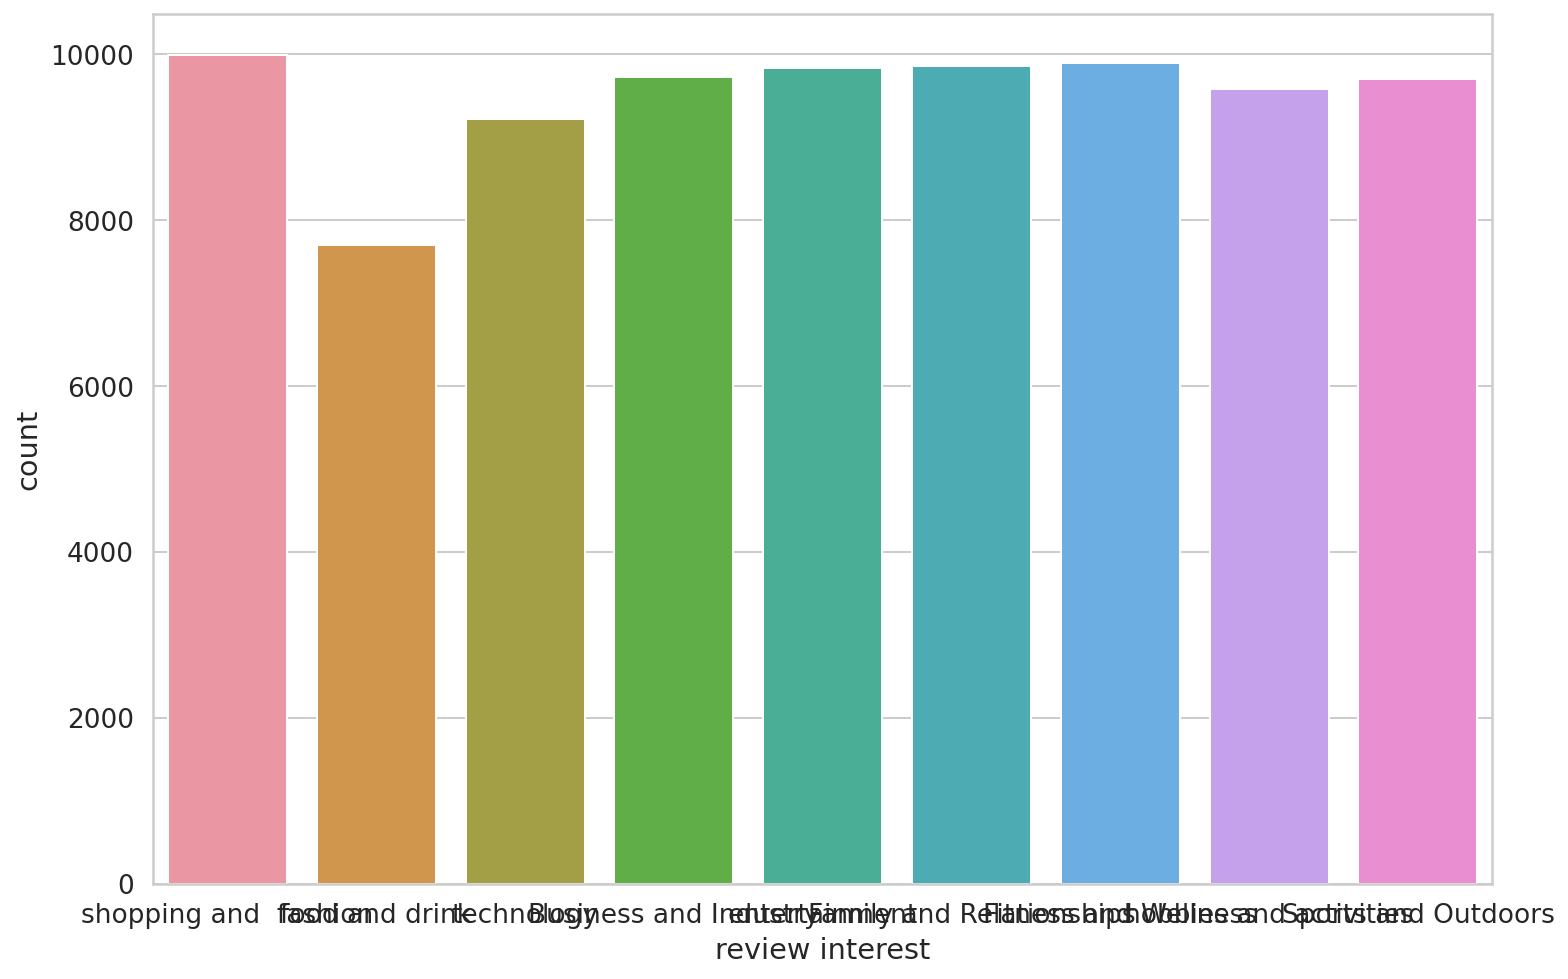

In [21]:
sns.countplot(df.interest)
plt.xlabel('review interest');
print("sahh congoloxicomatisation")

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [0]:
rev_dict = {'shopping and  fashion':0, 'food and drink':1, 'technology':2,
           'business and industry':3, 'entertainment':4,
            'family and relationships':5, 'fitness and wellness':6,
             'hobbies and activities':7, 'sports and outdoors':8}
def to_interest(interest):
  return rev_dict[interest.lower()]


df['category'] = df.interest.apply(to_interest)

In [0]:
class_names=['shopping and  fashion', 'food and drink', 'technology',
       'business and industry', 'entertainment',
       'family and relationships', 'fitness and wellness',
       'hobbies and activities', 'sports and outdoors']

Text(0.5, 0, 'review sentiment')

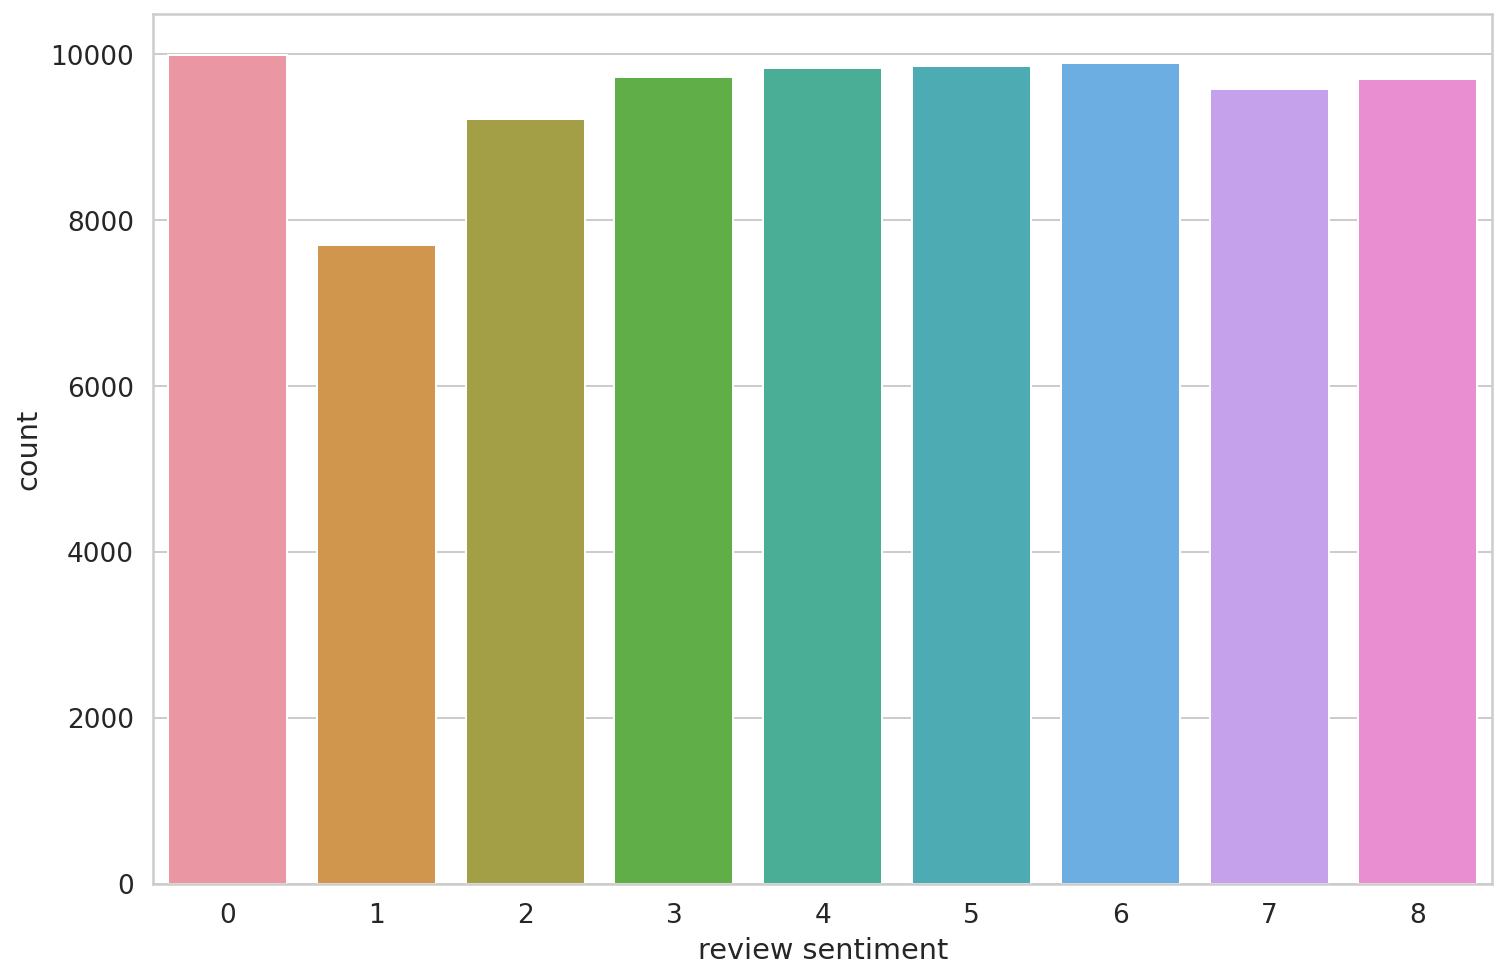

In [28]:
ax = sns.countplot(df.category)
plt.xlabel('review sentiment')
#ax.set_xticklabels(class_names);

In [29]:
df.head(150005)

,captions,interest,category
0,Hit the link in our bio to see our latest inte...,shopping and fashion,0
1,Caption this,shopping and fashion,0
2,"Alright, alight, alright. Here's @officiallymc...",shopping and fashion,0
3,Here's why a peak lapel grey overcoat is alway...,shopping and fashion,0
4,"Kit Harington, making travelling in style look...",shopping and fashion,0
...,...,...,...
87814,"DOMINANCE 20 years ago, on his 28th birthday, ...",sports and outdoors,8
87815,LeBron put up ridiculous numbers when he was 2...,sports and outdoors,8
87816,Tom Brady picks the strawweight queen to defen...,sports and outdoors,8
87817,For @shaq's 48th birthday we present a Shaq-ti...,sports and outdoors,8


The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [31]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [0]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [33]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [34]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [35]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [36]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [37]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [38]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()
print(encoding)

{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}


The token ids are now stored in a Tensor and padded to a length of 32:

In [39]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [40]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [41]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [0]:
token_lens = []

for txt in df.captions:
  txt=str(txt)
  if txt!=None:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

and plot the distribution:

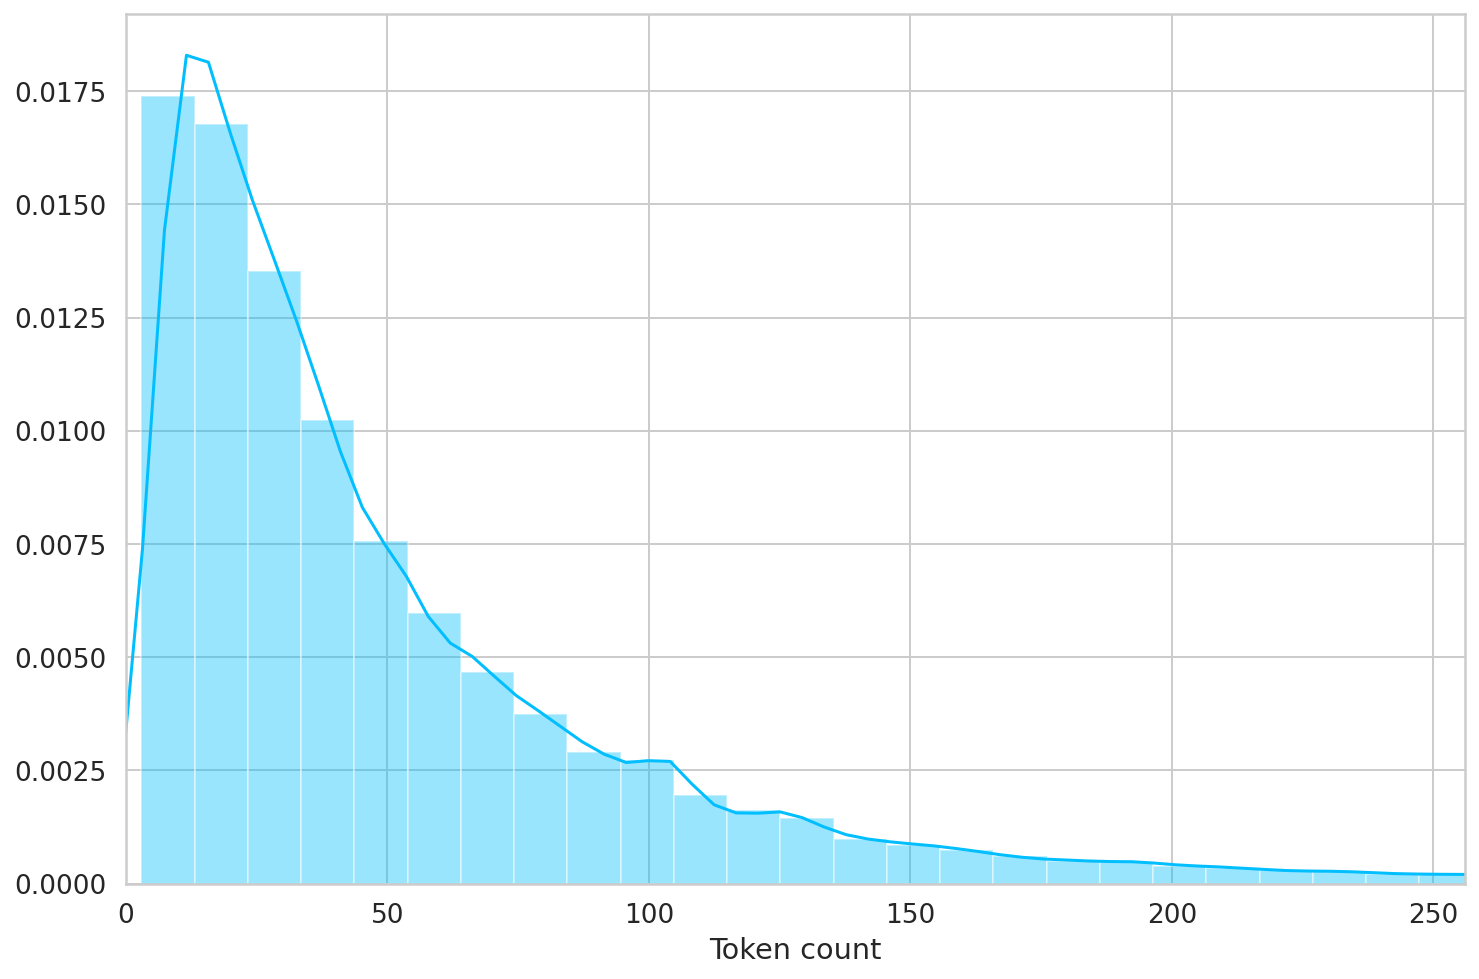

In [43]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [0]:
MAX_LEN = 150


We have all building blocks required to create a PyTorch dataset. Let's do it:

In [0]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [0]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [47]:
df_train.shape, df_val.shape, df_test.shape

((68401, 3), (8550, 3), (8551, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.captions.to_numpy(),
    targets=df.category.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE =16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [50]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [51]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [52]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [0]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [81]:
last_hidden_state.shape
last_hidden_state[0][0].shape

torch.Size([768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [82]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [83]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [0]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [0]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [86]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [87]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0632, 0.0756, 0.1578, 0.1743, 0.0987, 0.1019, 0.0869, 0.1380, 0.1033],
        [0.1083, 0.0786, 0.0945, 0.0655, 0.1291, 0.0890, 0.1046, 0.2046, 0.1260],
        [0.0881, 0.0909, 0.1303, 0.1221, 0.1811, 0.1258, 0.0936, 0.0604, 0.1078],
        [0.0880, 0.0755, 0.0649, 0.0982, 0.1706, 0.1610, 0.1112, 0.1668, 0.0639],
        [0.0695, 0.1050, 0.0631, 0.1157, 0.1394, 0.1584, 0.1613, 0.1198, 0.0678],
        [0.0263, 0.1351, 0.0452, 0.1809, 0.1502, 0.0913, 0.1225, 0.1519, 0.0965],
        [0.0584, 0.0813, 0.1682, 0.1779, 0.1051, 0.1471, 0.0662, 0.0872, 0.1085],
        [0.1409, 0.1299, 0.0606, 0.0889, 0.1349, 0.1216, 0.0690, 0.1671, 0.0870],
        [0.0715, 0.0698, 0.1054, 0.1160, 0.0966, 0.0930, 0.0888, 0.2221, 0.1367],
        [0.0495, 0.0794, 0.0838, 0.1139, 0.1521, 0.0958, 0.0795, 0.1856, 0.1605],
        [0.0937, 0.1116, 0.1064, 0.0831, 0.1192, 0.1423, 0.0662, 0.1716, 0.1060],
        [0.0448, 0.1370, 0.0897, 0.0962, 0.1147, 0.1042, 0.1475, 0.1153, 0.1506],
        [0.0845,

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [0]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [154]:
print(device)

cuda:0


Using those two, we can write our training loop. We'll also store the training history:

In [155]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    folder_path="/content/gdrive/My Drive/interest_dataset_folder/saved_Model/"
    file_name="interest_trained_model.pth"
    torch.save(model.state_dict(),folder_path+file_name)
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.3004900822041328 accuracy 0.906317159105861
Val   loss 0.4852217970885963 accuracy 0.8624561403508773

Epoch 2/8
----------
Train loss 0.1623732473568815 accuracy 0.9541380973962369
Val   loss 0.5505364399137863 accuracy 0.8719298245614036

Epoch 3/8
----------
Train loss 0.0956271857814297 accuracy 0.9746494934284586
Val   loss 0.714346548850065 accuracy 0.8739181286549708

Epoch 4/8
----------
Train loss 0.06323535124604895 accuracy 0.9845323898773409
Val   loss 0.7643811958740389 accuracy 0.8797660818713451

Epoch 5/8
----------
Train loss 0.03548926206512971 accuracy 0.9911843394102425
Val   loss 0.8686685550528535 accuracy 0.8811695906432749

Epoch 6/8
----------
Train loss 0.022798045495676593 accuracy 0.9943714273183141
Val   loss 0.8993500169656719 accuracy 0.8850292397660819

Epoch 7/8
----------
Train loss 0.013652851059335877 accuracy 0.9965643777137762
Val   loss 0.9321616406799111 accuracy 0.8852631578947369

Epoch 8/8
----------
Train los

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

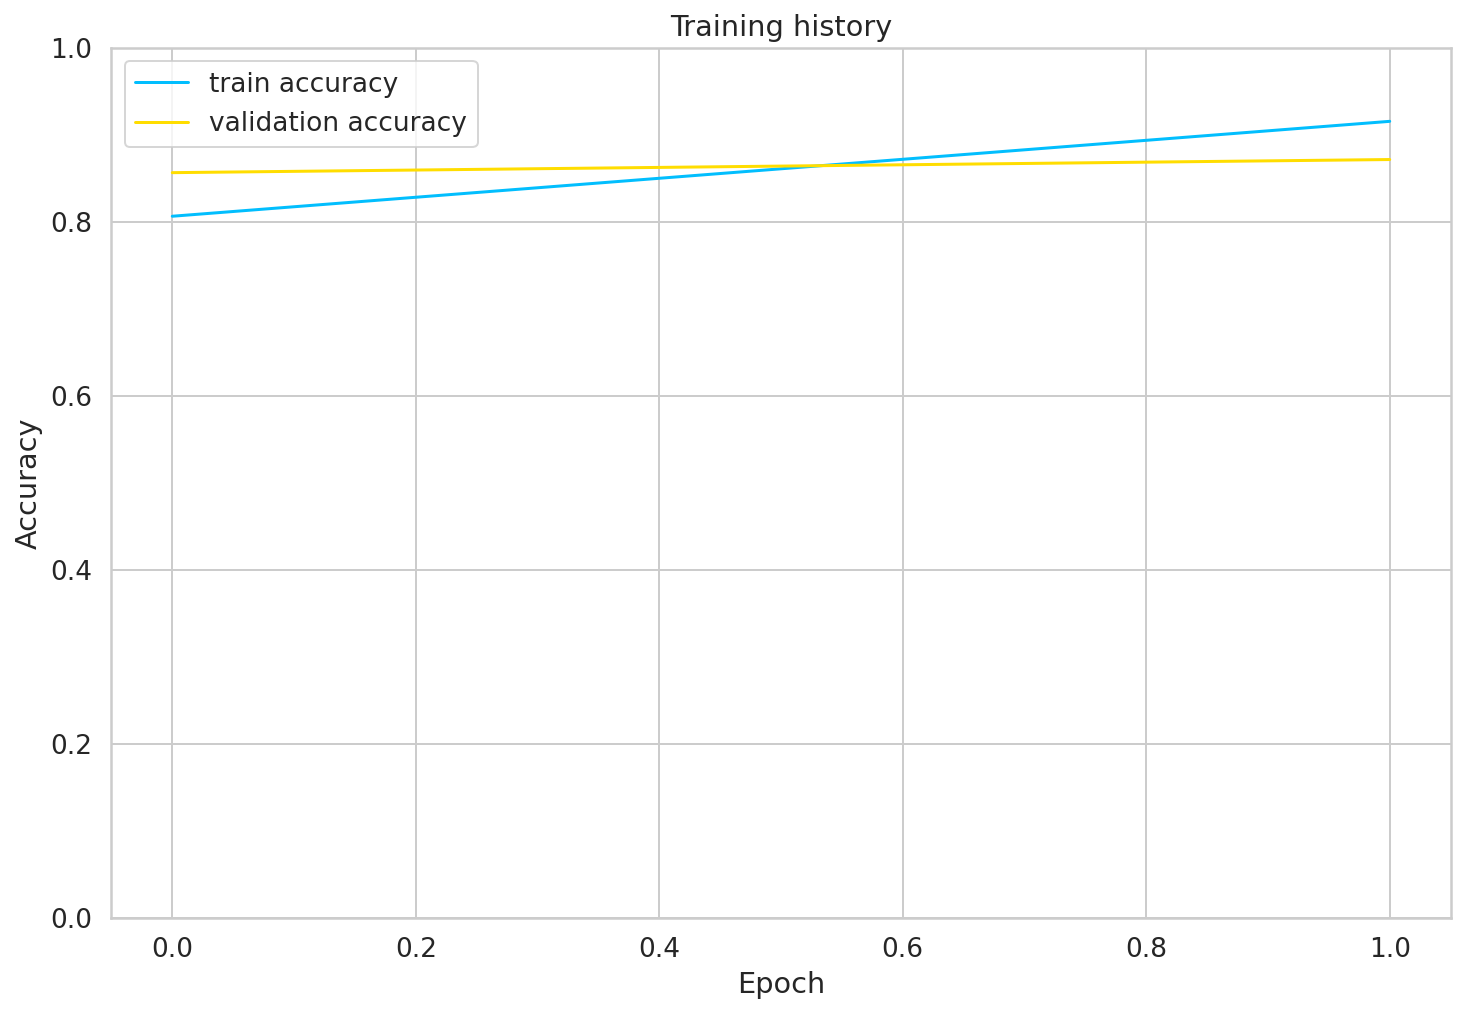

In [93]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [94]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8772073441702725

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [97]:
print(classification_report(y_test, y_pred, target_names=class_names))

                          precision    recall  f1-score   support

   shopping and  fashion       0.97      0.95      0.96      1026
          food and drink       0.85      0.86      0.85       773
              technology       0.85      0.85      0.85       896
   business and industry       0.84      0.84      0.84       939
           entertainment       0.82      0.85      0.83       973
family and relationships       0.92      0.89      0.90       988
    fitness and wellness       0.90      0.88      0.89      1051
  hobbies and activities       0.84      0.84      0.84       964
     sports and outdoors       0.90      0.92      0.91       941

                accuracy                           0.88      8551
               macro avg       0.88      0.88      0.88      8551
            weighted avg       0.88      0.88      0.88      8551



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

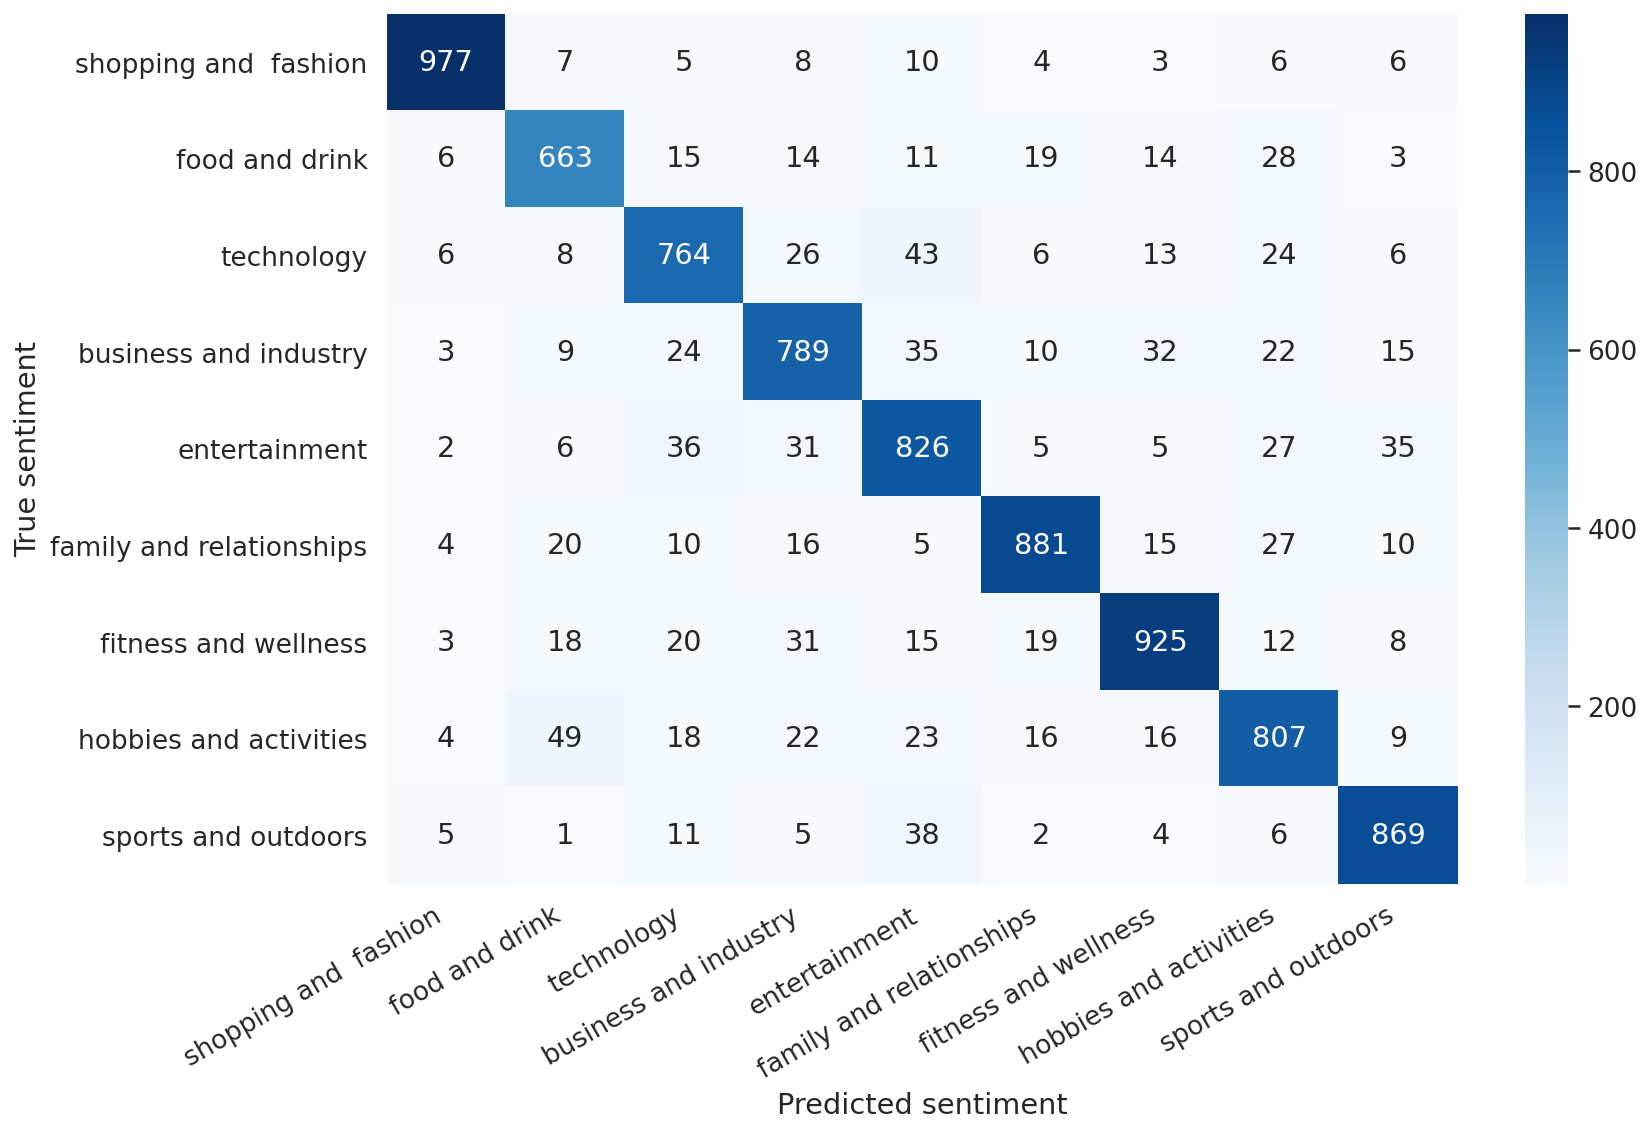

In [98]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [0]:
idx = 500

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [100]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

We love to laugh

True sentiment: business and industry


Now we can look at the confidence of each sentiment of our model:

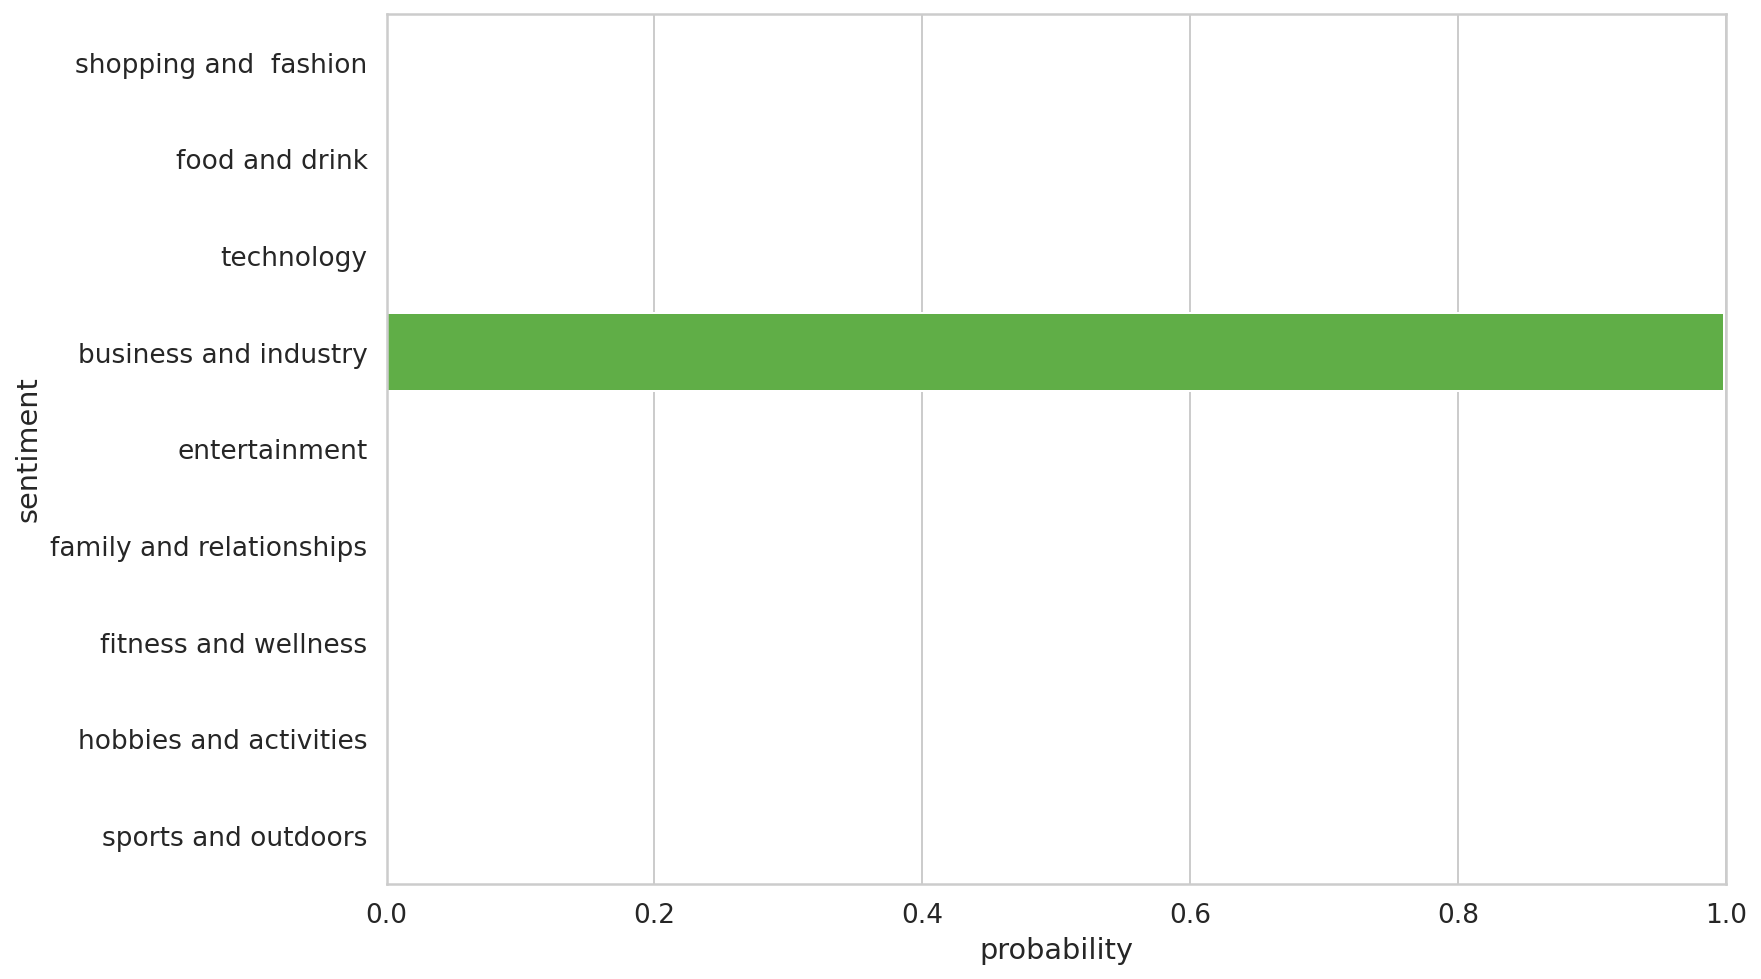

In [101]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [0]:
review_text = "I love pizza and eating fruits very much "

We have to use the tokenizer to encode the text:

In [0]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [104]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love pizza and eating fruits very much 
Sentiment  : fitness and wellness


In [0]:
def get_sentiment(review_text):

  encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print(output)
  print(prediction)
  print(class_names)
  print(f'Review text: {review_text}')
  print(f'Sentiment  : {class_names[prediction]}')



In [148]:
review_text="As far as anyone else knows, we're a nice, normal family. It's not what we have in our life, but who we have in our life that matters Ohana means family. Family means nobody gets left behind or forgotten I look at you and I'm home."
get_sentiment(review_text)

tensor([[-2.2473,  2.6999, -0.9252,  0.5960, -2.2116, -1.2946,  4.0106,  1.5161,
         -3.8465]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([6], device='cuda:0')
['shopping and  fashion', 'food and drink', 'technology', 'business and industry', 'entertainment', 'family and relationships', 'fitness and wellness', 'hobbies and activities', 'sports and outdoors']
Review text: As far as anyone else knows, we're a nice, normal family. It's not what we have in our life, but who we have in our life that matters Ohana means family. Family means nobody gets left behind or forgotten I look at you and I'm home.
Sentiment  : fitness and wellness


Processing file and data for testing 


In [0]:
def create_test_dataframe(input_file):
  col_list = ["captions"]
  folder_path="/content/gdrive/My Drive/interest_dataset_folder/test/"
  cur_path=folder_path+input_file+".csv"
  test_df=[]
  if path.exists(cur_path):
    test_df=pd.read_csv(cur_path, usecols=col_list,engine='python',
                            encoding='utf-8', error_bad_lines=False)
    test_df = test_df.dropna()
    test_df.head()
    return test_df

In [0]:
def get_prediction_array(review_text):

  encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  return output

In [0]:
import numpy as np

In [0]:
def get_interest(test_df):
  predictions=[0,0,0,0,0,0,0,0,0]
  iteration=0
  for caption in test_df["captions"]:
    prediction=get_prediction_array(caption)
    prediction=prediction[:].detach().cpu().numpy()
    predictions=predictions+prediction
    iteration=iteration+1
  data_len=len(test_df["captions"])
  if data_len>0 :
    predictions=(1/data_len)*predictions

  print(iteration)
  print(predictions)
  print(class_names)
  max_index =np.argmax(predictions)
  print(f'Interest  : {class_names[max_index]}')

Saving  model Parameters

In [0]:
folder_path="/content/gdrive/My Drive/interest_dataset_folder/saved_Model/"
file_name="interest_trained_model.pth"
torch.save(model.state_dict(),folder_path+file_name)

Loading model parameters

In [0]:
folder_path="/content/gdrive/My Drive/interest_dataset_folder/saved_Model/"
file_name="interest_trained_model.pth"
state_dict = torch.load('/content/gdrive/My Drive/interest_dataset_folder/saved_Model/trained_model.pth')

In [0]:
model = SentimentClassifier(len(class_names))

In [72]:
model.load_state_dict(state_dict)

RuntimeError: ignored

In [0]:
model = model.to(device)

Testing Part

In [0]:
#this function take account name and create dataframe for test
user_account="richardbiedul"
test_df=create_test_dataframe(user_account)

In [165]:
get_interest(test_df)

122
[[-1.44495934 -1.2528879   0.26876353  7.55515146  0.61120014 -1.34261111
  -0.32614862 -0.23065267 -1.39091832]]
['shopping and  fashion', 'food and drink', 'technology', 'business and industry', 'entertainment', 'family and relationships', 'fitness and wellness', 'hobbies and activities', 'sports and outdoors']
Interest  : business and industry
